In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import pickle

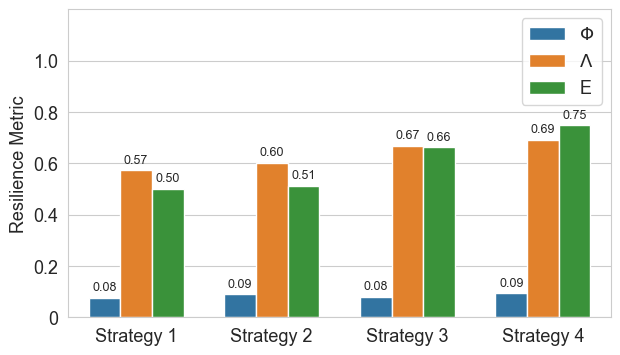

In [72]:
mg_id = 2
get_s = lambda i: pd.read_csv(f'Results/(MG{mg_id})optimal(sc{i}).csv')
s1, s2, s3, s4 = [get_s(i) for i in range(1, 5)]
cols = ['Phi', 'Lambda', 'E']
get_r = lambda df: df[cols].values[0,:]
r1, r2, r3, r4 = [get_r(s) for s in [s1, s2, s3, s4]]
plt.rcParams.update({'font.size': 13})  # or any size you want

df = {
    'x': np.array([[f'Strategy {i+1}']*3 for i in range(4)]).flatten(),
    'y': np.concatenate([r1, r2, r3, r4]),
    'label': np.stack([r'$\Phi$', r'$\Lambda$', 'E']*4),
    'color': np.stack(['#ed8e3b', '#3a4191', '#329453']*4)}
fig = plt.figure(figsize=(7, 4))
ax = sns.barplot(data=df, x='x', y='y', hue='label', width=0.7)
# Add text labels on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', padding=3, fontsize=9)

plt.ylim([0, 1.2])
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], [0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.ylabel('Resilience Metric')

plt.savefig(f'IMG/(MG{mg_id})resilience.jpg', dpi=600, bbox_inches='tight')

### Economic Plots

In [62]:
vars = {i: {} for i in range(3)}
costs = {i: {} for i in range(3)}
pars = {i: {} for i in range(3)}
for i in range(3):
    for s in range(27):
        with open(f'Solutions/(MG{i}){s}.pkl', 'rb') as file:
            vars[i][s], costs[i], pars[i] = pickle.load(file)

In [63]:
from Data import ModelsData
data = {0: ModelsData(0), 1: ModelsData(1), 2: ModelsData(2)}
i_range = range(3)
s_range = range(27)
# Sale to households (annual)
e_load = np.array([d.e_load for d in data.values()])
sale = np.array([np.average([vars[i][s]['y_esl'].sum() + vars[i][s]['y_pvl'].sum() + vars[i][s]['y_dgl'].sum() for s in s_range], weights=data[0].Pr) for i in i_range])
revenue = sale * e_load * (data[0].to_year/2)

In [64]:
# Sale to grid (annual)
e_grid = np.array([d.e_grid_export for d in data.values()])
sale = np.array([np.average([vars[i][s]['y_pvgrid'].sum() for s in s_range], weights=data[0].Pr)
        for i in i_range])
gridsale = sale * e_grid * (data[0].to_year/2)

In [65]:
# Fuel cost savings
pv_power = np.array([np.average([vars[i][s]['y_pvl'].sum() + vars[i][s]['y_pves'].sum() for s in s_range],
               weights=data[0].Pr) for i in i_range])
dg_power = np.array([np.average([vars[i][s]['y_dgl'].sum() + vars[i][s]['y_dges'].sum() for s in s_range],
               weights=data[0].Pr) for i in i_range])
fuel_saving = dg_power / (pv_power + dg_power)

In [66]:
# ES utilization rate (daily)
charge = np.array([np.average([vars[i][s]['y_pves'].sum() + vars[i][s]['y_dges'].sum() for s in s_range],
               weights=data[0].Pr) for i in i_range])
discharge = np.array([np.average([vars[i][s]['y_esl'].sum() for s in s_range],
               weights=data[0].Pr) for i in i_range])
utilize = charge + discharge
capacity = np.array([111, 82, 88])
utilize_rate = (utilize) / (capacity * (2 * 4 * 24))

In [67]:
# CO2 abatement (emission factors (kg Co2/kWh): Grid electricity 0.4–0.5, Diesel generator 0.69–0.75
dg_power = np.array([np.average([vars[i][s]['y_dgl'].sum() + vars[i][s]['y_dges'].sum() for s in s_range],
               weights=data[0].Pr) for i in i_range])
pv_power = np.array([np.average([vars[i][s]['y_pvl'].sum() + vars[i][s]['y_pves'].sum() for s in s_range],
               weights=data[0].Pr) for i in i_range])
baseline = (dg_power + pv_power) / 2
actual = (dg_power) / 2
co2_abatement = 0.7 *(baseline - actual) # kg per year

In [68]:
table = {'Sale to community': revenue,
         'Sale to grid': gridsale,
         'Fuel cost saving': fuel_saving,
         'Utilization': utilize_rate,
         'co2': co2_abatement}
pd.DataFrame(table).to_csv('Results/economic.csv', index=False)

### Scaling plots

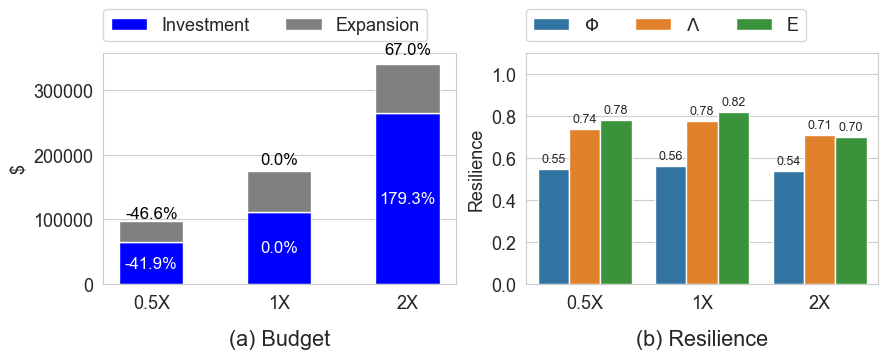

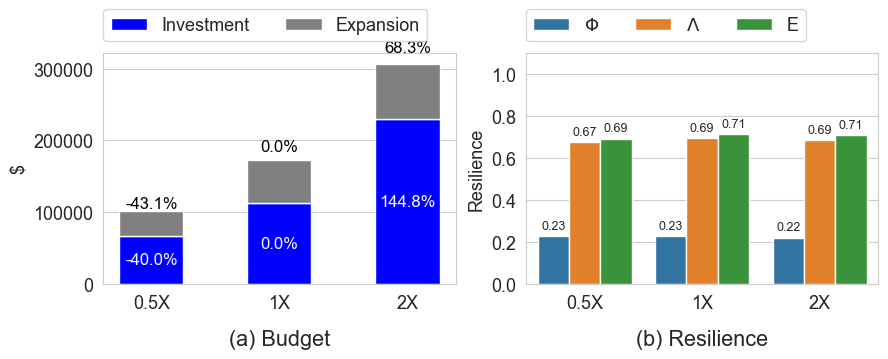

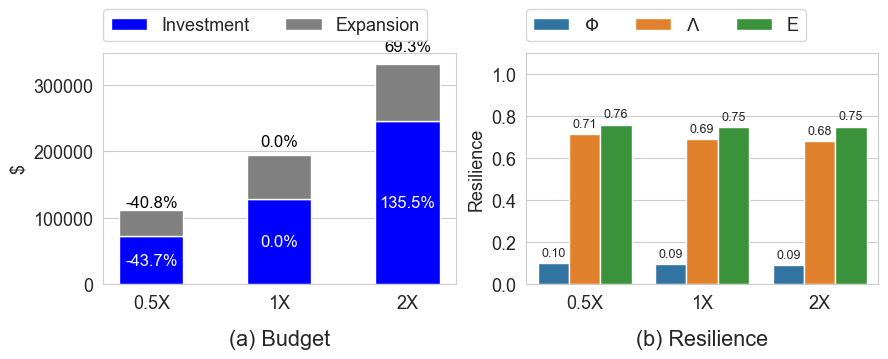

In [81]:
import seaborn as sns
plt.rcParams.update({'font.size': 13})  # or any size you want
i_index = range(3)
scale = ['scale0.5', 'sc4', 'scale2']
d0 = [pd.read_csv(f'Results/(MG0)optimal({s}).csv') for s in scale]
d1 = [pd.read_csv(f'Results/(MG1)optimal({s}).csv') for s in scale]
d2 = [pd.read_csv(f'Results/(MG2)optimal({s}).csv') for s in scale]
d = [d0, d1, d2]

def get_change(df, key):
    half = df[0][key].values[0]
    base = df[1][key].values[0]
    double = df[2][key].values[0]
    change = [(half-base)/base, 0, (double-half)/base]
    return change
change = [get_change(d0, 'Investment'), get_change(d1, 'Investment'), get_change(d2, 'Investment')]
change_e = [get_change(d0, 'Expansion'), get_change(d1, 'Expansion'), get_change(d2, 'Expansion')]
x, xticks = [0, 1, 2], ['0.5X', '1X', '2X']
for i in i_index:
    # Mg i
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 3))

    y_i = np.array([ds['Investment'].values[0] for ds in d[i]])
    y_e = np.array([ds['Expansion'].values[0] for ds in d[i]])
    ax0.bar(x, y_i, label='Investment', color='blue', width=0.5)
    ax0.bar(x, y_e, bottom=y_i, label='Expansion', color='gray', width=0.5)
    for ii, yy in enumerate(y_i):
        ax0.text(x[ii], yy/2, f'{change[i][ii]*100:0.1f}%', color='white', fontsize=12, ha='center', va='center')
    for ii, yy in enumerate(y_e):
        ax0.text(x[ii], 1.3*yy + y_i[ii], f'{change_e[i][ii]*100:0.1f}%', color='black', fontsize=12, ha='center', va='center')
    ax0.set_xticks(x, xticks)
    ax0.set_ylabel('$')
    ax0.legend(ncol=2, loc=[0, 1.05])
    ax0.grid(axis='x')
    ax0.set_title('(a) Budget', y=-0.3)

    df = {
    'x': np.array([[x]*3 for x in xticks]).flatten(),
    'y': np.concatenate([ds[['Phi', 'Lambda', 'E']].values[0] for ds in d[i]]),
    'label': np.stack([r'$\Phi$', r'$\Lambda$', 'E']*3),
    'color': np.stack(['#ed8e3b', '#3a4191', '#329453']*3)}
    ax1 = sns.barplot(data=df, x='x', y='y', hue='label', width=0.8)
    for container in ax1.containers:
        ax1.bar_label(container, fmt='%.2f', label_type='edge', padding=3, fontsize=9)
    ax1.set_ylim([0, 1.1])
    ax1.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    ax1.legend(ncol=3, loc=[0, 1.05])
    ax1.set_ylabel('Resilience')
    ax1.set_title('(b) Resilience', y=-0.3)
    plt.savefig(f'IMG/(MG{i})scale.jpg', dpi=600, bbox_inches='tight')